<a href="https://colab.research.google.com/github/jav0927/course-v3/blob/master/SSD_Object_Detection_RS50_V2_0_AutoAugmented.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Improving Deep Learning Performance with Google's AutoAugment (SSD Version 3.0)
This notebook uses data augmentation techniques for optimized vision object detection. We apply the results from the Auto Augment Algorithm developed by Google Brain Team and documented in the paper "AutoAugment: Learning Augmentation Policies from Data" by Ekin D. Cubuk, Barret Zoph, Dandelion Mane, Vijay Vasudevan, Quoc V. Le. Last revision: 11 April 2019. Results are impressive.

AutoAugment is an automatic method of designing custom data augmentation policies for computer vision datasets. This notebook implements the policy created by the AutoAugment algorithm for the ImageNet dataset.

We purposedly chose to train in a small PASCAL dataset: 4000 training images and 1000 validation images. We wanted to prove Google's assertion that use of the AutoAugent policy is specially beneficial for small datasets. The results of our tests amply confirm this.

The major benefits of applying the AutoAugment-derived policy are:
1. Greater training accuracy. Using standard Fastai transformations, we could only achieve, at the most, 15% training loss error. Using the AutoAugment policy we were able to bring the training loss error down to about 9%.
2. Much greater stability during training. Google claims that applying the  policy improves L1 regularization. And that seems to be the case.

It is to be noted that we are using here a pretty basic SSD implementation. 

The details of the policy implementation are given in the section "Google's AutoAugment - Optimized data augmentation for ImageNet" 

### Version Date: 01/22/2020. 
A. Villalobos, @ 2019, 2020. wolves.lair@icloud.com

### Initialization

In [0]:
# Hardware performance enhancements
import os
NUM_PARALLEL_UNITS = 4
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["KMP_BLOCKTIME"] = "0"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"] = "granularity=fine, verbose, compact, 1, 0"

In [0]:
# Set up online plotting
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
# Connect Google drive to Colab for file saving and loading.
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# For use in Auto Augment data transformations
import random
import torchvision.transforms.functional as FT

In [0]:
# Load Fastai libraries
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
__version__

'1.0.60'

In [0]:
# Automatically sets for GPU or CPU environments
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

###Download Pascal 20007 database

In [0]:
# Download {Pascal 20007 database}
path = untar_data(URLs.PASCAL_2007); path.ls()

[PosixPath('/root/.fastai/data/pascal_2007/valid.json'),
 PosixPath('/root/.fastai/data/pascal_2007/test.json'),
 PosixPath('/root/.fastai/data/pascal_2007/train.json'),
 PosixPath('/root/.fastai/data/pascal_2007/train'),
 PosixPath('/root/.fastai/data/pascal_2007/test')]

### Data Preparation

In [0]:
# Collect image names, bound box coordinates, and categories into lists
# for train and test data sets
trn_im_names, trn_truths = get_annotations(path/'train.json')
val_im_names, val_truths = get_annotations(path/'valid.json')
tst_im_names, tst_truths = get_annotations(path/'test.json') 

# Combine Train and Validation set into a sigle dataset
# (which will be split later by the data block)
tot_im_names, tot_truths = [trn_im_names + val_im_names, trn_truths + val_truths]

# Create a dictionary containing the composite of the above
img_y_dict = dict(zip(tot_im_names, tot_truths))

# Define a function, based on the dictionary created above, to use in a Fastai Data Block to structure the input data
truth_data_func = lambda o: img_y_dict[o.name]

### ** Google's AutoAugment - Optimized data augmentation for ImageNet  **
The ImageNet policy used in this notebook consists of 21 sub-policies. Each sub-policy includes a tuple of transformations, along with their respective intensity values and probabilities of firing. Most of the transformations affect pixel values. i.e. color, invert, contrast, etc. Two transformations  affect pixel coordinate values: rotation and horizontal shear.

Since Fastai does not implement pixel-value transformations (except for a couple), we had to implement them using Pillow. Furthermore, we needed to implement rotation and horizontal shear because these transformations affect the bounding boxes as well as the images.

To each image in a mini-batch, we apply a random sub-policy. Each transformation has a discretized intensity level and probability of firing. The policy needs to map these discretized values to actual parameter values for each PIL transformation. We set batch size to 32, instead of 64, so that the images could be exposed to a greater variety of transformations.

Fastai's Data Block lacks the flexibility to support access to the individual image within a minibatch. It is true that the Databunch has a dl_tfms parameter that allows access to the minibatch; however, anything one does in dl_tfms is propagated to both the train_dl and the valid_dl. The result of these shortcomings is that one needs to implement a hybrid augmentation method, part using the data block, and part outside of it.

#### Data Augmention Transformations
This cell implements the rotation and the horizontal shear bounding box transformations.

In [0]:
# HELPER FUNCTIONS
def fastai2pil_basis(b) :  return ((b + 1.)).div(2.)      # Convert to PIL image basis (0,0) to (1,1)         
def pil2fastai_basis(b):  return (b * 2.).float() - 1.    # Convert to FASTAI image basis (-1,-1) to (1,1) 
def flip_horizontal(bboxes):                              # This method flips a negative transformation into positive one, thus avoiding coding complexity
  bboxes[:,[1,3]] = torch.flip(bboxes[:,[1,3]], [1])      # Swap the (x) columns: 1, and 3
  bboxes[:,[1, 3]] *= -1;                                 # Flip the sign of each of these columns
  return bboxes
def rotate_bb(bc, rads):            
    M = torch.tensor([                         # Rotation Matrix
           [cos(rads), -sin(rads)],         
           [sin(rads),  cos(rads)]
           ] ).to(device)           
    return torch.mm(M,bc.to(device))           #  Rotate bounding box, as given by "degrees"   


# SHEAR-HORIZONTALLY BOUNDING BOXES
def shear_x_bboxes (bboxes, factor):
  ''' 
    Shear horizontally a set of bounding boxes corresponding to a given image
          bboxes :      A set of bounding boxes associated with the image
          factor :      Factor by which the image in sheared in the X direction
  '''
  m = bboxes[(bboxes == 0.).all(1)]                                     # Retain the all-zero rows
  bboxes = bboxes[~(bboxes == 0.).all(1)]                               # Retain the non all-zero rows
  mag = factor                                                          # If the factor is negative, flip the boxes about the (0,0) center
  if factor <= 0 : mag = -factor; bboxes = flip_horizontal(bboxes)      # so it can be sheared correctly (in the positive orientation)
  bboxes = fastai2pil_basis(bboxes)                                     # Convert to PIL image basis (0,0) to (1,1)       
  bboxes[:,[1,3]] = bboxes[:,[1,3]] + bboxes[:,[0,2]]  * mag            # Shear in the horizontal direction (to the right)
  bboxes = pil2fastai_basis(bboxes)                                     # Convert to FASTAI image basis (-1,-1) to (1,1)
  if factor <= 0 : bboxes = flip_horizontal(bboxes)                     # If factor is negative, restore the boxes to the original orientation
  bboxes = torch.clamp(bboxes, -1, 1)                                   # Clamp coordinates to [-1, 1]
  bboxes = torch.cat([m, bboxes], dim=0)                                # Graft the all-zero rows back to the bounding box array
  return bboxes


# ROTATE BOUNDING BOXES
def rotate_bboxes(bboxes, degrees):
  ''' 
    Create a bounding Box for a rotated image
        bboxes :        A single bounding box
        degrees :       Angle in degrees to rotate the image
  '''
  rads = math.radians(degrees)                                          # Convert degrees to radians   
  m = bboxes[(bboxes == 0.).all(1)]                                     # Retain the all-zero rows of the bounding box
  bboxes = bboxes[~(bboxes == 0.).all(1)]                               # Retain the non all-zero rows of the bounding box
  lgt = abs(bboxes[:,[1]] - bboxes[:,[3]])                              # Calculate the length of the box in the x axis
  mag = rads                                                            # If degrees is negative, flip the boxes about the (0,0) center
  if degrees <= 0 : mag = -rads; bboxes = flip_horizontal(bboxes)       # so it can be rotated correctly (in the positive orientation)
  bboxes = bboxes.reshape(-1,2).transpose(1,0)                          # Put tensor into a (n x 2) vertical array
  bboxes = rotate_bb(bboxes, mag).transpose(0,1).reshape(-1,4)          # # Rotate bounding box and restore coordinates to fastai image basis 
  bboxes [:,[0]] = bboxes [:,[0]] - (lgt)*sin(mag)                      # Calculate the delta-lenght to add and substract to 
  bboxes [:,[2]] = bboxes [:,[2]] + (lgt)*sin(mag)                      #   the y coordinates to compensate for the rotation
  if degrees <= 0 : bboxes = flip_horizontal(bboxes)                    # If degrees is negative, restore the boxes to the original orientation
  bboxes = torch.clamp(bboxes, -1, 1)                                   # Clamp coordinates to [-1, 1]
  bboxes = torch.cat([m, bboxes], dim=0)                                # Graft the all-zero rows back to the bounding box array
  return bboxes

#### Data Augmentation Algorithm
This class is the heart of the data augmentation algorithm.  It picks up a random sub_policy that it then applies to an image in a minibatch. For each transformation in the sub-policy tuple, it maps the discretized intensity and probability to the actual PIL transformation. It is very fast. It can easily be expanded to support other dataset, such as COCO.

In [0]:
class ImageNetPolicy():
    '''
    Augmentation policy for the ImageNet Dataset.
    (According to the paper Learning Data Augmentation Strategies for Object detection. Barret Zoph, et. al. 6/26/2019)
    The Policy is composed of a series of sub-policies. 
    Each sub-policy contains two (2) augmentation steps. i. e. 'posterize', 'rotate'
    Each step consists of:
          (1) an operation i.e. 'posterize', 
          (2) probability of application. i.e. 0.4, and
          (3) magnitude indicating the intensity of the operation
    Author:  J. Adolfo Villalobos @ 2020 
    '''
    def __init__(self, fillcolor=(128, 128, 128)):
        
        self.policy = [
            SubPolicy("posterize", 0.4, 8, "rotate",       0.6, 9, fillcolor),
            SubPolicy("solarize",  0.6, 5, "autocontrast", 0.6, 5, fillcolor),
            SubPolicy("equalize",  0.8, 8, "equalize",     0.6, 3, fillcolor),
            SubPolicy("posterize", 0.6, 7,"posterize",     0.6, 6, fillcolor),
            SubPolicy("equalize",  0.4, 7,"solarize",      0.2, 4, fillcolor),

            SubPolicy("equalize",  0.4, 4, "rotate",       0.8, 8, fillcolor),
            SubPolicy("solarize",  0.6, 3, "equalize",     0.6, 7, fillcolor),
            SubPolicy("posterize", 0.8, 5, "equalize",     1.0, 2, fillcolor),
            SubPolicy("rotate",    0.2, 3, "solarize",     0.6, 8, fillcolor),
            SubPolicy("equalize",  0.6, 8, "posterize",    0.4, 6, fillcolor),

            SubPolicy("rotate",    0.8, 8, "color",        0.4, 0, fillcolor),
            SubPolicy("rotate",    0.4, 9, "equalize",     0.6, 2, fillcolor),
            SubPolicy("equalize",  0.0, 7, "equalize",     0.8, 8, fillcolor),
            SubPolicy("invert",    0.6, 4, "equalize",     1.0, 8, fillcolor),
            SubPolicy("color",     0.6, 4, "contrast",     1.0, 8, fillcolor),

            SubPolicy("rotate",    0.8, 8, "color",        1.0, 2, fillcolor),
            SubPolicy("color",     0.8, 8, "solarize",     0.8, 7, fillcolor),
            SubPolicy("sharpness", 0.4, 7, "invert",       0.6, 8, fillcolor),
            SubPolicy("shearX",    0.6, 5, "equalize",     1.0, 9, fillcolor),
            SubPolicy("color",     0.4, 0, "equalize",     0.6, 3, fillcolor),

            SubPolicy("equalize",  0.4, 7, "solarize",     0.2, 4, fillcolor),
            SubPolicy("solarize",  0.6, 5, "autocontrast", 0.6, 5, fillcolor),
            SubPolicy("invert",    0.6, 4, "equalize",     1.0, 8, fillcolor),
            SubPolicy("color",     0.6, 4, "contrast",     1.0, 8, fillcolor),
            SubPolicy("equalize",  0.8, 8, "equalize",     0.6, 3, fillcolor)
        ]
            
    
    def __call__(self, x, y):
      '''Fetch a random sub-policy'''
      policy_idx = random.randint(0, len(self.policy) - 1)
      #print(F'Pol_idx: {policy_idx}')
      return self.policy[policy_idx](x, y)

    def __repr__(self):
        return "AutoAugment Policy Applicable to the ImageNet Dataset. " 
 
# ********************************

class SubPolicy():
    def __init__(self, operation1, p1, magnitude_idx1, operation2, p2, magnitude_idx2, fillcolor=(128, 128, 128)):
        '''
        The magnitude that is specified for each subpolicy item is a number from 1 to 10.
        This number translates to a separate measure which varies for each operation. The specific measure
        is picked up from a range of uniformly spaced physical attribute values according to the dictionary below.
        '''
        ranges = {
            "shearX": np.linspace(-0.3, 0.3, 10),     
            "shearY": np.linspace(-0.3, 0.3, 10),     
            "translateX": np.linspace(-150, 150 / 331, 10),
            "rotate": np.linspace(-30, 30, 10),        
            "color": np.linspace(0.1, 1.9, 10),
            "posterize": np.round(np.linspace(8, 4, 10), 0).astype(np.int),
            "solarize": np.linspace(256, 0, 10),
            "contrast": np.linspace(0.1, 1.9, 10),
            "sharpness": np.linspace(0.1, 1.9, 10),
            "brightness": np.linspace(0.1, 1.9, 10),
            "autocontrast": [0] * 10,
            "equalize": [0] * 10,
            "invert": [0] * 10
        }
       
        # Custom rotate with fill       
        def rotate_with_fill(img: PIL.Image, yb, mag):
            ob = rotate_bboxes(yb, mag)
            #print(F"Rotate: {mag}")
            rot = img.convert("RGBA").rotate(mag)    # Rotate the image
            return [PIL.Image.composite(rot, PIL.Image.new("RGBA", rot.size, (128,) * 4), rot).convert(img.mode), ob]

        def shear_horizontal (img: PIL.Image, yb, mag):
            #print(F"Rotate: {mag}")  
            trb = mag*random.choice([-1, 1])
            tri = (1, -trb, 0, 0, 1, 0)
            b_tf = img.transform(img.size, PIL.Image.AFFINE, tri, PIL.Image.BICUBIC)
            ob = shear_x_bboxes (yb, trb)                 
            return [b_tf, ob]

        # Transform functions
        func = {

            "rotate": lambda img, yp, magnitude: rotate_with_fill(img, yp, magnitude),
            "shearX": lambda img, yp, magnitude: shear_horizontal(img, yp, magnitude), 
            "color": lambda img, yp, magnitude: [PIL.ImageEnhance.Color(img).enhance(magnitude), yp],
            "posterize": lambda img, yp, magnitude: [PIL.ImageOps.posterize(img, magnitude), yp],
            "solarize": lambda img, yp, magnitude: [PIL.ImageOps.solarize(img, magnitude), yp],
            "contrast": lambda img, yp, magnitude: [PIL.ImageEnhance.Contrast(img).enhance(
                1 + magnitude * random.choice([-1, 1])), yp],
            "sharpness": lambda img, yp, magnitude: [PIL.ImageEnhance.Sharpness(img).enhance(
                1 + magnitude * random.choice([-1, 1])), yp],
            "brightness": lambda img, yp, magnitude: [PIL.ImageEnhance.Brightness(img).enhance(
                1 + magnitude * random.choice([-1, 1])), yp],
            "autocontrast": lambda img, yp, magnitude: [PIL.ImageOps.autocontrast(img), yp],
            "equalize": lambda img, yp, magnitude: [PIL.ImageOps.equalize(img, mask=None), yp],
            "invert": lambda img, yp, magnitude: [PIL.ImageOps.invert(img), yp]
        }
        
        
        # Probabilities
        self.p1 = p1; self.p2 = p2
        
        #  Fetch a Fastai transform corresponding to the given subpolicy step operation
        self.operation1 = func[operation1]; self.operation2 = func[operation2]
        self.magnitude1 = ranges[operation1][magnitude_idx1]; self.magnitude2 = ranges[operation2][magnitude_idx2]
        
    # Randomized filtering
    def __call__(self, x, y):       
         # Tensor to PIL image
        img = FT.to_pil_image(x.data.cpu(), mode='RGB')     
        # Fetch a Fastai-formatted transform corresponnding to the given Subpolicy
        if random.random() < self.p1: img, y = self.operation1(img, y, self.magnitude1)
        if random.random() < self.p2: img, y = self.operation2(img, y, self.magnitude2)
        img = pil2tensor(img, dtype=np.float32).div(255)   # Revert to FASTAI Image format        
        return [img, y]      # returns the, transformed image and corresponding bounding boxes
       

#### Data Augmentation - Interface to the Data Block
This method uses the DataBunch dl_tfms parameter to access a minibatch. It cycles through each image in the minibatch and applies a randomly selected sub-policy. Unfortunately, the transformation is also applied to the valid_dl and we need to reset the validation dataset later, as inndicated below

In [0]:
def aug_tfms(b:Collection[Tensor]):
    xb, yb = b
    for i in range (xb.shape[0]):   
      # Aply a random subpolicy to each image in the batch         
      new_input = policy(xb[i], yb[0][i])
      new_img, new_bboxes = new_input
      # update image and bboxes into the batch
      xb[i] = new_img; 
      yb[0][i] = new_bboxes   
      yb[1][i] = yb[1][i]
          
    return xb, yb

#### Create Fastai DataBunch
Please note that the data augmentation transformations are being fed into the databunch via the dl_tfms parameter. Also, the data bunch does not include normalization because the valid_dl is, at this point, tainted.


In [0]:
# Tried to apply random-crop to the valid dataset, but was unable to make it work. The valid_dl seems to work fine with no transformations at all.
tfmss = [],[RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)]

In [0]:
sz=224       # Image size
bs=32        # Batch size
np.random.seed(35)

In [0]:
# Instantiate the augmentation policy class
policy = ImageNetPolicy()

# Create a data bunch
data = (ObjectItemList
        .from_folder(path/'train')
        .split_by_rand_pct()
        .label_from_func(truth_data_func) 
        .transform(size=sz,tfm_y=True,resize_method=ResizeMethod.SQUISH)
        .databunch(bs=bs,collate_fn=bb_pad_collate,num_workers=8, dl_tfms=aug_tfms)
       )

In [0]:
# restore the valid_dl dataset to its original , un-tranformed, form.
data.valid_dl.tfms = []

In [0]:
# Apply normalization to both train_dl and valid_dl
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (4009 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /root/.fastai/data/pascal_2007/train;

Valid: LabelList (1002 items)
x: ObjectItemList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: ObjectCategoryList
ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224),ImageBBox (224, 224)
Path: /root/.fastai/data/pascal_2007/train;

Test: None

### Show batch from validation dataset
Please note that the data in the train_dl has undergone transformations as per the data augmentation policy. The bounding boxes have been transformed accordingly.

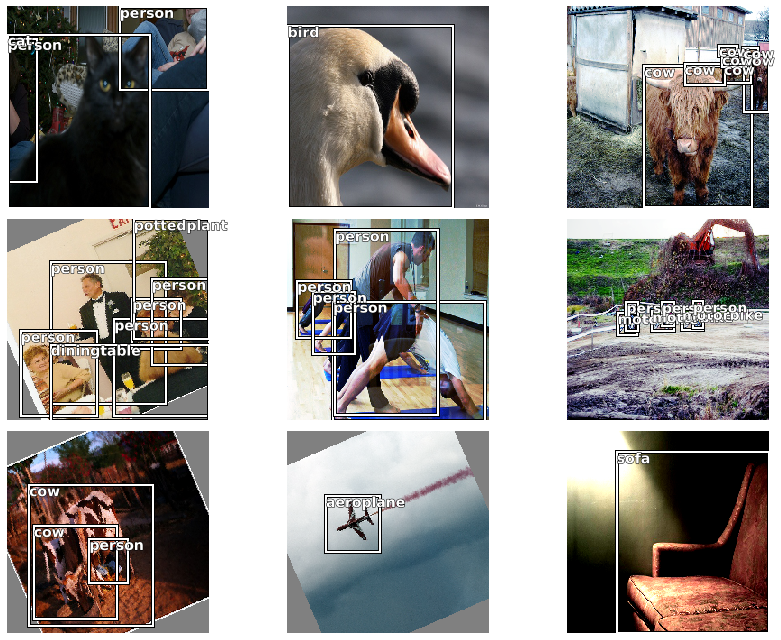

In [0]:
data.show_batch(rows=3, figsize=(12,9))

### Show single image from validation dataset
Validation images are not transformed in any way.

In [0]:
# Show test image
idx = 30
bt = iter(data.valid_dl)

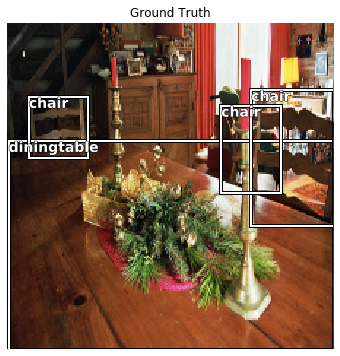

In [0]:
xb, yb= next(bt)

img = vision.Image(denormalize(xb[idx], *tensor(imagenet_stats)))
img_box = ImageBBox.create(sz, sz, yb[0][idx].cpu(), labels=yb[1][idx], classes=data.classes, scale=False)

fig, axes = plt.subplots(1, 1, figsize=(10,6))
img.show(ax=axes, y=img_box, title="Ground Truth")

### Helper Functions 

In [0]:
# Filter out all zero-valued bounding boxes
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

# Calculate the area of a bounding box
def box_area(boxes):
    return (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])

# Calculate the intersection of two given bounding boxes
def intersect(box_a,box_b):
    #make sure box_a and box_b exists, otherwise undefine behavior if you call the func
    top_left = torch.max(box_a[:,None,:2],box_b[None,:,:2])
    bot_right = torch.min(box_a[:,None,2:],box_b[None,:,2:])
    inter = torch.clamp((bot_right - top_left),min=0)
    return inter[:,:,0] * inter[:,:,1]

# Calculate Jaccard (IOU)
def iou(bbox,anchor):
    #bbox is gt_bb, anchor is anchor box, all in fastai style
    if len(bbox.shape) == 1: bbox = bbox[None,...]
    inter = intersect(bbox,anchor)
    union = box_area(bbox).unsqueeze(dim=1) + box_area(anchor).unsqueeze(dim=0) - inter #to broadcast shape to (N,16),where N is number of gt_bb for single image
    return inter / union

# Display generated anchor grid
def show_anchors(ancs, size):
    _,ax = plt.subplots(1,1, figsize=(5,5))
    ax.set_xticks(np.linspace(-1,1, size[1]+1))
    ax.set_yticks(np.linspace(-1,1, size[0]+1))
    ax.grid(True, which='both')
    ax.scatter(ancs[:,1], ancs[:,0]) #y is first
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_xlim(-1,1)
    ax.set_ylim(1,-1) #-1 is top, 1 is bottom
    for i, (x, y) in enumerate(zip(ancs[:, 1], ancs[:, 0])): ax.annotate(i, xy = (x,y))

#convert center/height/width to fastai top left and bottom right coordinates
def cthw2corners(boxes):
    top = (boxes[:,0] - boxes[:,2]/2).view(-1,1)
    left = (boxes[:,1] - boxes[:,3]/2).view(-1,1)
    bot = (boxes[:,0] + boxes[:,2]/2).view(-1,1)
    right = (boxes[:,1] + boxes[:,3]/2).view(-1,1)
    return torch.cat([top,left,bot,right],dim=1)

# Transform activations to bounding box format
def act_to_bbox(activation,anchor):
    activation = torch.tanh(activation) #force scale to be -1,1
    act_center = anchor[:,:2] + (activation[:,:2]/2 * grid_sizes.float().to(activation.device))
    act_hw = anchor[:,2:] * (activation[:,2:]/2 + 1)
    return cthw2corners(torch.cat([act_center,act_hw],dim=1))

# Map to Ground Truth
def map_to_gt(overlaps):
    prior_overlap,prior_idx = overlaps.max(dim=1)
    sec_overlap,sec_idx = overlaps.max(dim=0)
    sec_overlap[prior_idx] = 4.99
    for i,o in enumerate(prior_idx): 
        sec_idx[o] = i
    return sec_overlap,sec_idx

### Helper Functions - Anchor Boxes

In [0]:
# Anchor Boxes
anc_grids = [4, 2, 1]
anc_zooms = [0.75, 1., 1.3]
anc_ratios = [(1., 1.), (1., 0.5), (0.5, 1.)]

anchor_scales = [(anz*i,anz*j) for anz in anc_zooms 
                                    for (i,j) in anc_ratios]
# *** Number of Anchor Scales
k = len(anchor_scales)
# ***************************

anc_offsets = [2/(o*2) for o in anc_grids] #2 is the h,w in fastai 1.0 (-1,1)
anc_x = np.concatenate([np.repeat(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao-1, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)
anc_sizes = np.concatenate([np.array([[2*o/ag,2*p/ag] 
              for i in range(ag*ag) for o,p in anchor_scales])
                 for ag in anc_grids]) #2/grid * scale,2 is the h,w in fastai 1.0
grid_sizes = tensor(np.concatenate([np.array([ 1/ag 
              for i in range(ag*ag) for o,p in anchor_scales])
                  for ag in anc_grids])).unsqueeze(1) *2 #again fastai 1.0 h,w is 2
anchors = tensor(np.concatenate([anc_ctrs, anc_sizes], axis=1)).float()
anchor_cnr = cthw2corners(anchors)


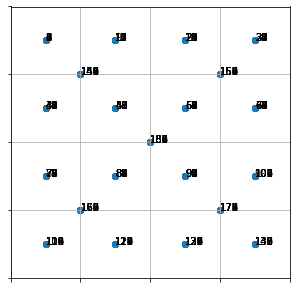

In [0]:
show_anchors(anchors,(4,4))

### Optimal Learning Rate Search
This is my own version of Fastai's learn.recorder.plot(). For an explanation of how it works and how to use it, go to my post Selecting Learn Rates in Fastai, https://forums.fast.ai/t/selecting-learn-rates-in-fastai/51929

In [0]:
# Helper function
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model.body[-1][0].parameters()):
      if each.requires_grad: c += 1   
    if c == len(list(learner.model.body[-1][0].parameters())):
      return True 
    else:
      return False
    
  
# Find candidate learning rates, as given by points of inflection in the loass and loss-gradient curves
def find_optimal_lr(learner, noise=4, show_df=None, show_min_values=False):
    '''
    Parameters
    
      learner:  The learner (mandatory)
      
      (Optional)
      noise:   Filtering parameter, set to 4. Used to fine-tune output
      
      show_df: 'head' - Show the top 50 rows, 
               'tail' - Show the tail 50 rows
    
      show_min_values: True  - Display all values, min, and max 
                       False - Display min_loss and max_grad values
    
    Returns:
      optimun_lr - if freeze = True
      Suggested top-3 lr values - if freeze = False
      
    Author:  J. Adolfo Villalobos @ 2019  
    '''
    
    # Get loss values, corresponding gradients, and lr values from model.recorder
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss) 

    # Transform lrs list to np array
    lrs = np.array(learner.recorder.lrs, dtype='float32')
    
    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])
      
    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema
    
    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 4 seems to work best
    n=noise    
    #********
    
    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     
        
    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss, label='loss' )
    
    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])
   
    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad, label='loss_grad' )
    ax2.tick_params(axis='y', labelcolor = color_grad)
    
    # plot inflection points
    ax.scatter(df.lrs, df.min_loss, c = color_red, label='min_loss' )    
    ax2.scatter(df.lrs, df.min_grad, c = color_red, label='min_grad' )    
    if show_min_values:
      ax.scatter(df.lrs, df.max_loss, c = color_green, label='max_loss' )
      ax2.scatter(df.lrs, df.max_grad, c = color_green, label='max_grad' ) 
    
    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()
    
    # Display resulting lr values, format varies depending of the state of the model's 
    # next-to-last layer ggroup: set to freeze or unfreeze    
    if is_unfreeze(learner):
      # Yellow min_grad graph
      rev_tru_idx = df.min_grad.notna()[::-1]   
      optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
      rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
      
      # Blue loss graph
      rev_tru_idx_loss = df.min_loss.notna()[::-1]   
      optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
      rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
      optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
      
      # Print results and return choices of lr slice
      print('Model set to: "unfreeze" or "freeze_to:"')      
      data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
              '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
      prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
      pd.options.display.float_format = '{:.10E}'.format
      #prdf.style.applymap('color: %s' % color_grad, subset=['*Gradient - Orange Graph*'])
      print(prdf)
       
      return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g
      
    else:
        
      optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
      optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
      # Print results and return optimal lr
      print('Model set to "freeze":')
      print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
      print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
      return optimun_lr_upper_bound 
     

### Preserve data classes for use in Validation and Testing

In [0]:
# Number of classes in the data set
no_cls = len(data.classes)
print(F'Number of classes: {no_cls}') 

Number of classes: 21


In [0]:
# Copy Data Classes for Future Use in Testing External Images
data_classes = data.classes.copy()
# Save the Classes in a file for use later in the section that predicts external images (which can be run on a separate computer)
with open(F'/content/gdrive/My Drive/ssd_classes', 'wb') as fp:
    pickle.dump(data_classes, fp)

### Model

To solve this object detection problem, we are going to create a custom model using Torch.
The architecture chosen is Single Shot Detection, described in the paper SSD: Single Shot Multibox Detector by Wei Liu, et. al.
The model uses a pretrained ResNet, to which we add the components required for object detetion. The chosen backbone architecture is ResNet50.

In [0]:
# model based on RESNET50
f_model = models.resnet50

In [0]:
# Model Building Blocks
# Method used to match the shape of the conv_ssd_layer to the ground truth's shape
def y_handoff (x,k):
    # Reshape ssd output to match truth's shape 
    # Must return size of bs,r*c,nf
    # y structure is (16,4),(16,21) single item style
    bs,nf,row,col = x.shape
    x = x.view(bs,nf//k,-1)
    return x.permute(0,2,1) 

# Standard convolution with stride=2 to halve the size of the image
class conv2_std_layer(nn.Module):
    def __init__(self, ni, nf, stride=2, drop=0.1):    # Was 0.1
        super().__init__()
        self.cnv = conv_layer(ni, nf, stride=stride)
        self.drp = nn.Dropout(drop)
        
    def forward(self, x):
        return self.drp(self.cnv(x))

# SSD convolution that camptures bounding box and class
class conv2_ssd_layer(nn.Module):
    def __init__(self, ni, k, no_cls):
        super().__init__()
        self.k = k 
        self.conv_class = conv2d(ni, no_cls*self.k, bias=True)
        self.conv_bbox = conv2d(ni, 4*self.k, bias=True)
           
    def forward(self, x):
        label = self.conv_class(x)
        box = self.conv_bbox(x)
        return [y_handoff(box, self.k), y_handoff(label, self.k)]

In [0]:
# SSD Model
class ssd_model(nn.Module):
    def __init__(self, arch=models.resnet34, k=9 , drop=0.4, no_cls=21):
        super().__init__()
        self.k = k
        self.body = create_body(arch)
        self.drop = nn.Dropout(0.25)   # it was 0.25

        self.std_conv_0 = conv2_std_layer(num_features_model(self.body), 256, drop=drop,stride=1)
        # Dimension-reducing  layers
        self.std_conv_1 = conv2_std_layer(256, 256, drop=drop, stride=2) # 4 by 4 layer
        self.std_conv_1_1 = conv_layer(256, 256, stride=1)  # Booster layer
        self.std_conv_2 = conv2_std_layer(256, 256, drop=drop, stride=2) # 2 by 2 layer
        self.std_conv_1_2 = conv_layer(256, 256, stride=1)  # Booster layer
        self.std_conv_3 = conv2_std_layer(256, 256, drop=drop, stride=2) # 1 by 1 layer
        # SSD layers
        self.ssd_conv_1 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_2 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        self.ssd_conv_3 = conv2_ssd_layer(256, k=self.k, no_cls=no_cls)
        
    def forward(self, xb):
        xb = self.drop(F.relu(self.body(xb)))
        xb = self.std_conv_0(xb)
        xb = self.std_conv_1(xb)
        xb = self.std_conv_1_1(xb)
        bb1, cls1 = self.ssd_conv_1(xb) # 4 x 4
        xb = self.std_conv_2(xb)
        xb = self.std_conv_1_2(xb)
        bb2, cls2 = self.ssd_conv_2(xb) # 2 x 2
        xb = self.std_conv_3(xb)     
        bb3, cls3  = self.ssd_conv_3(xb) # 1 x 1
        
        return [torch.cat([bb1, bb2, bb3], dim=1), 
                torch.cat([cls1, cls2, cls3], dim=1)]

### SSD Loss

---


In [0]:
# Focal loss implementation
def get_weight(x,t):
    x,t = x.cpu(),t.cpu()
    alpha,gamma = 0.25,1
    p = x.sigmoid()
    pt = p*t + (1-p)*(1-t)
    w = alpha*t + (1-alpha)*(1-t)
    return w * (1-pt).pow(gamma)
    
# Class loss computation, based on Binary Cross Entrophy with Logits
def bceloss(pred,target,num_classes,focal_loss=False):
    
    t = torch.eye(num_classes)[target.detach().cpu()][:,1:]
    p = pred[:,1:]
    
    w = get_weight(p,t) if focal_loss else None
    return F.binary_cross_entropy_with_logits(p.cpu(),t,weight=w.detach(),reduction='sum') / (num_classes-1)

# Bounding-box loss computation, based on fixed Anchor Boxes and L1 Loss
def single_ssd_loss(pbox,plabel,box,label):
    # IOU Threshold. Keep overlaps with iou above this level
    threshold = 0.4
    
    # Compute the jaccard (overlap) between ground truth and anchor boxes
    anchor_box = anchors
    base_box = cthw2corners(anchor_box) # Map anchors into Fastai format: top-left and bottom-right coordinates
    bbox,clas = un_pad(box,label) # Filter all non-zero boxes
    overlaps = iou(bbox,base_box.to(device))  # Calculate iou for anchor and target box
    try:
        gt_overlaps,gt_idx = map_to_gt(overlaps)
    except:
        return 0,0
    # Map gt_idx back to classes for multi label classfication
    gt_clas = clas[gt_idx]
    
    # Positive predictions have overlaps greater than 0.4
    pos = gt_overlaps > threshold

    #************************************************
    # Fix for "mask inversion problem" in PyTorch 1.2 (10/22/19)
    gt_clas[~pos] = len(data.classes)
    # ***********************************************

    gt_label = [o.item() if o < len(data.classes) else 0 for o in gt_clas.detach()] #Ground truth labels
    pos_idx = torch.nonzero(pos)[:,0] 
    gt_bbox = bbox[gt_idx]  # Selected ground truth box
    
    # Map predicted bounding box to anchor and convert it to Fastai format: top-left and bottom-right coordinates
    p_final_box = act_to_bbox(pbox,anchor_box.to(device)) 
    
    #L1 loss calculation
    loc_loss = ((p_final_box[pos_idx] - gt_bbox[pos_idx]).abs()).mean()
    
    #Multi classification
    label_loss = bceloss(plabel,tensor(gt_label),data.c,focal_loss=True)
    return loc_loss,label_loss

# Loop through each of the y_hat and y pairs 
def ssd_loss(preds,*targets,print_it=False):
    batch_loc_loss,batch_label_loss = 0., 0.
    for p_box,p_label,box,label in zip(*preds,*targets):
        loc_loss,label_loss = single_ssd_loss(p_box,p_label,box,label)
        batch_loc_loss = batch_loc_loss + loc_loss
        batch_label_loss = batch_label_loss + label_loss
    total_loss = batch_loc_loss + batch_label_loss.to(device)
    if print_it: print(batch_loc_loss,batch_label_loss)
    return total_loss
  
# loss function
loss_f = ssd_loss

### Learner

In [0]:
md = ssd_model(f_model, k=k, no_cls=no_cls, drop=0.55)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s] 


In [0]:
learn = Learner(data, md, loss_func=loss_f)

### Split Model

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
#learn.layer_groups

### Fit

#### initial Training Run (on freeze)

In [0]:
# Find Finder
learn.freeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


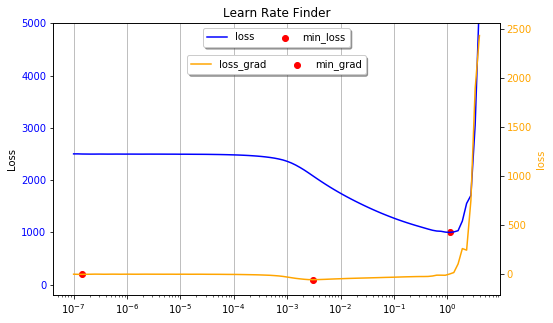

Model set to "freeze":
  Optimun lr: 3.0199517496E-03 
  Min loss divided by 10: 1.0964782238E-01


In [0]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn, noise=5);

In [0]:
learn.fit_one_cycle(5, slice(3.0199517496E-03  ) )

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_basic')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_basic', strict=True)

#### Train Last Two Layers

In [0]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


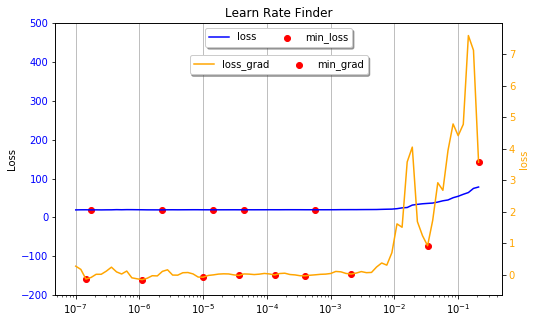

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            2.0892961323E-01     5.7543994626E-04
Second choice lr:           3.3113110811E-02     4.3651583837E-05
Third choice lr:            2.0892962348E-03     1.4454397387E-05


In [0]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(5, slice(5.7543994626E-04))     # 6.3095736550E-05

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_freeze_2_1_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_freeze_2_1_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6],m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


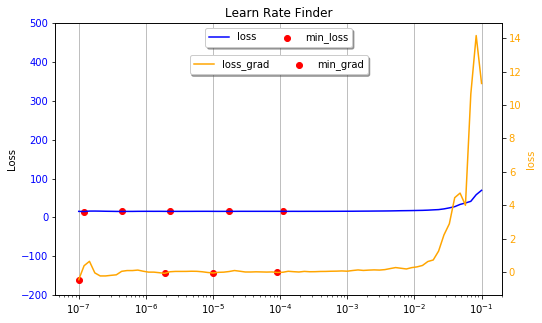

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            9.1201087344E-05     1.0964782268E-04
Second choice lr:           9.9999997474E-06     1.7378008124E-05
Third choice lr:            1.9054607492E-06     2.2908675419E-06


In [0]:
# Find Optimal Learning Rates
lr =  find_optimal_lr(learn, noise=6)

In [0]:
learn.fit_one_cycle(5, slice(1.0964782268E-04))     # 4.3651583837E-05 

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_2_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2_2_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


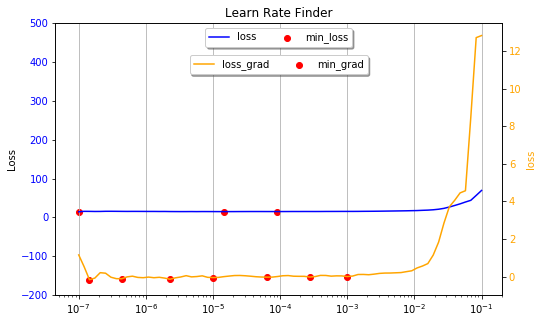

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            1.0000000475E-03     9.1201087344E-05
Second choice lr:           2.7542287717E-04     1.4454397387E-05
Third choice lr:            6.3095736550E-05     1.0000000117E-07


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(5, slice(2.7542287717E-04))    # 4.7863009968E-04

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_3_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2_3_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


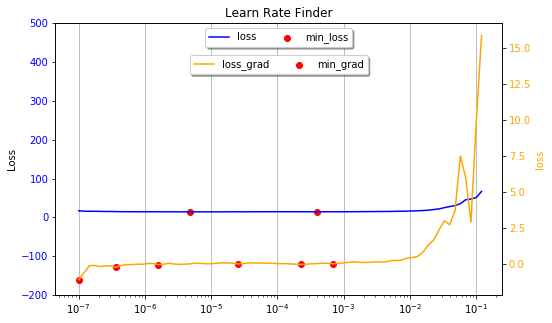

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            6.9183099549E-04     3.9810716407E-04
Second choice lr:           2.2908677056E-04     4.7863009058E-06
Third choice lr:            2.5118864869E-05     1.2022644281E-01


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(5, slice(3.9810716407E-04))    # 1.9054606673E-04

In [0]:
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_4_rs50')

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


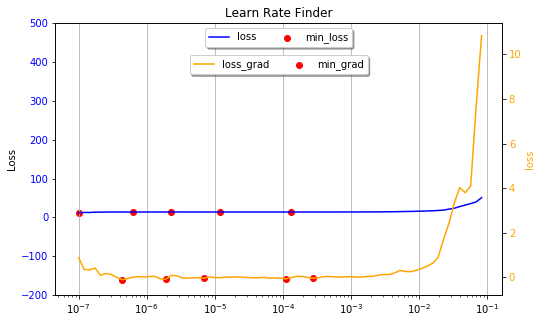

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            2.7542287717E-04     1.3182566909E-04
Second choice lr:           1.0964782268E-04     1.2022644114E-05
Third choice lr:            6.9183097366E-06     2.2908675419E-06


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(10, slice(2.7542287717E-04 ))    # 5.7543994626E-04
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_5_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2_5_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


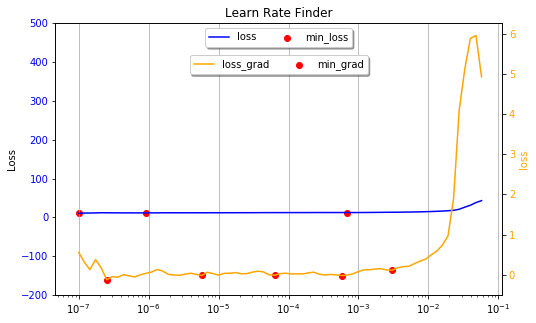

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.0199517496E-03     6.9183099549E-04
Second choice lr:           5.7543994626E-04     9.1201081887E-07
Third choice lr:            6.3095736550E-05     1.0000000117E-07


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(10, slice(6.9183099549E-04))    # 5.7543994626E-04
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_6_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_2_6_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.freeze_to(-2)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


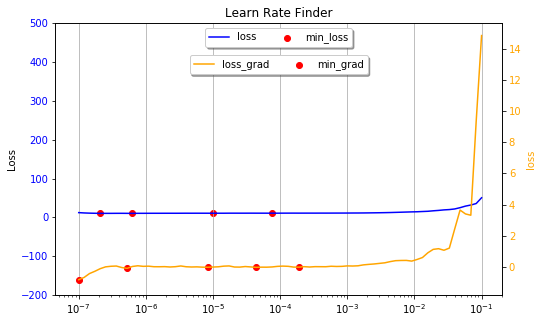

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            1.9054606673E-04     7.5857758929E-05
Second choice lr:           4.3651583837E-05     9.9999997474E-06
Third choice lr:            8.3176373664E-06     6.3095734504E-07


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(10, slice(1.9054606673E-04 ))    # 5.7543994626E-04
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_2_7_rs50')

#### Unfreeze and Train

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


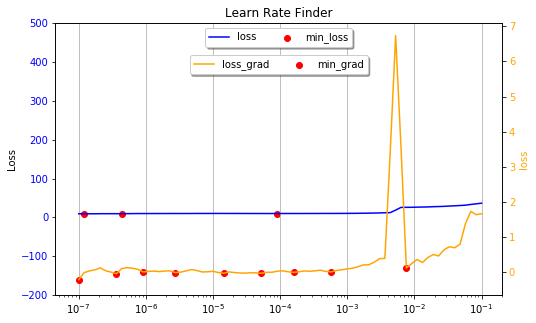

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            7.5857755728E-03     9.1201087344E-05
Second choice lr:           5.7543994626E-04     4.3651581905E-07
Third choice lr:            1.5848931798E-04     1.2022644569E-07


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(10, slice(9.1201087344E-05))
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_4_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_4_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


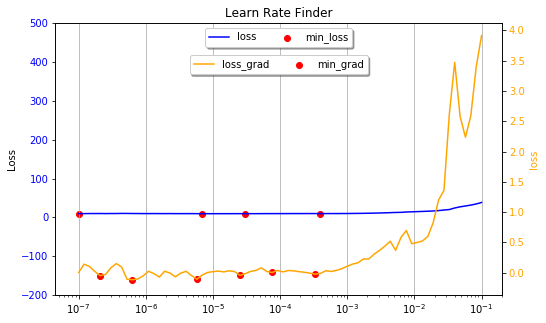

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            3.3113113022E-04     3.9810716407E-04
Second choice lr:           7.5857758929E-05     3.0199516914E-05
Third choice lr:            2.5118864869E-05     6.9183097366E-06


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(10, slice(3.9810716407E-04))
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_5_rs50')

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_5_rs50', strict=True)

In [0]:
learn.split(lambda m: (m.body[6], m.drop))
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


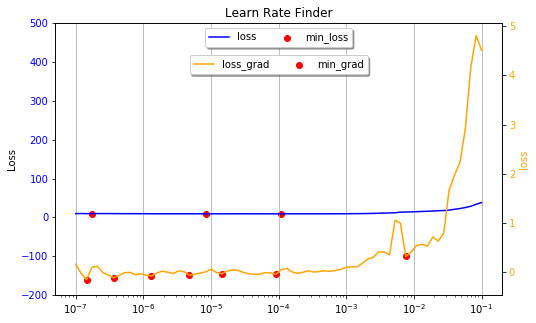

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            7.5857755728E-03     1.0964782268E-04
Second choice lr:           9.1201087344E-05     8.3176373664E-06
Third choice lr:            1.4454397387E-05     1.7378008010E-07


In [0]:
lr = find_optimal_lr(learn, noise=4)

In [0]:
learn.fit_one_cycle(10, slice(1.0964782268E-04))
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_6')

In [0]:
learn.fit_one_cycle(5, slice(4.7863009968E-04))
learn.save(F'/content/gdrive/My Drive/ssd_unfreeze_7')

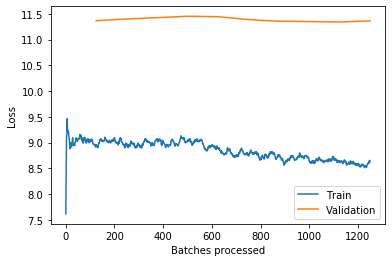

In [0]:
learn.recorder.plot_losses()

In [0]:
learn.load(F'/content/gdrive/My Drive/ssd_unfreeze_7', strict=True)

### Export Model
Export model into a .pkl file for use in testing of external images (perhaps in a different computer)

In [0]:
learn.export(F'/content/gdrive/My Drive/model_export.pkl')

### Infer validation images ( No NMS)

In [0]:
# Get batch from valid dataset
xb,yb = next(iter(learn.data.valid_dl))
xb.shape

torch.Size([32, 3, 224, 224])

In [0]:
# Infer results from valid dataset batch
learn.model.eval()
preds = learn.model(xb)

In [0]:
# Prepare images for display, given their indeces
def show_img_by_ndx(idx):
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=data.classes,scale=False)

    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    t_bbox = p_final_bbox.to(device).index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())
    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data.classes,scale=False)

    fig,axes = plt.subplots(1,2,figsize=(10,6))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction')

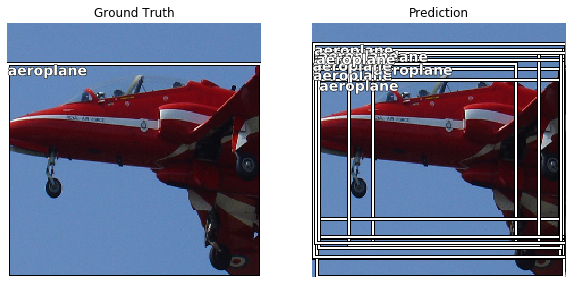

In [0]:
# Show single image
show_img_by_ndx(2)

### Color Coding Setup

In [0]:
# Bounding box and label color scheme
import matplotlib.cm as cmx
import matplotlib.colors as mcolors
from cycler import cycler

def get_cmap(N):
    color_norm  = mcolors.Normalize(vmin=0, vmax=N-1)
    return cmx.ScalarMappable(norm=color_norm, cmap='Set3').to_rgba

num_colr = 12
cmap = get_cmap(num_colr)
colr_list = [cmap(float(x)) for x in range(num_colr)]

### NMS  Algorithm

In [0]:
#  NMS Algorithm
def nms(boxes, scores, overlap=0.5, top_k=100):
    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0: return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        keep[count] = i
        count += 1
        if idx.size(0) == 1: break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

In [0]:
# Process NMS
def process_nmf(idx, d_classes):
    '''
    Connects to the nmf algorith to filter out dupplicate bounding boxes
    ''' 
    # Minimun threshold for eliminating background noise
    min_thresh = 0.25     #0.25
    
    # Maximun threshold for eliminating duplicate boxes
    max_thresh = 0.1 
    
     # Extract predicted classes
    clas_pr, clas_ids = b_clas[idx].max(dim=1)
    
    # Mask Index of classes whose contents are over the noise level: 0 if the index contains no boxes, 1 if it does
    clas_pr = clas_pr.sigmoid()    
    
    # Calculate confidence score for Class Activations
    conf_scores = b_clas[idx].sigmoid().t().data  
    
    # Converts activation vectors to boxes. Shape: 189 x 4
    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors) 
    
    # lists for accumulating selected boxes and classes
    tot_bx, tot_cls = [], []
    
    scrd_cls_lst = d_classes.copy()
  
    # Loop across all classes
    for cl in range(0, len(conf_scores)):
        
        # Filter out Backgrounds and empty box arrays
        c_mask = conf_scores[cl] > min_thresh
        if c_mask.sum() == 0 or cl == 0: continue
        
        
        # scores for the selected class 
        scores = conf_scores[cl][c_mask] # Tensor 
            
        # These are active boxes. Ready to be processed by nmf
        boxes = p_final_bbox.to(device).index_select(dim=0,index=c_mask.nonzero().squeeze())
            
        # Run NMF
        ids, count = nms(boxes.data, scores, overlap=0.5, top_k=50)
        ids = ids[:count]
          
        # Filter all boxes & classes over the threshold and accumulate them in lists
        for i, (sc, bx) in enumerate(zip(scores, boxes.data[ids] )): 
                 
            tot_bx.append(bx)
            tot_cls.append(cl)
            # Create a scored label
            f = f'{i}: '           
            l = f'{d_classes[cl]} '
            s = '{0:.2f}'.format(sc) 
            sl = f+l+s
            # print('scored label: {} '.format(sl))
            scrd_cls_lst[cl] = sl

                
    if not tot_cls:
        print('Inferred Class is not recognized. It may be under the threshold.')
        return None, None, None  
    
    return torch.cat(tot_bx).view(-1, 4), torch.tensor((np.array(tot_cls))), scrd_cls_lst

### Infer validation images with NMS

In [0]:
# Link to the valid data loader
tr = iter(learn.data.valid_dl)

In [0]:
# Get batch from the valid dataset
xb,yb = next(tr)

# Infer results 
learn.model.eval()
preds = learn.model(xb)
b_bb, b_clas = preds

#### Apply NMS to images and prepare them for display

In [0]:
# Filter images, given their indeces, and process them through NMS
def show_filtered_img_by_ndx(idx, d_classes):
        
    # Prepare ground-truth image for display
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))        
    img_box = ImageBBox.create(224,224,yb[0][idx].cpu(),labels=yb[1][idx],classes=d_classes,scale=False)
    
    # Unpad Y (ground-truth boxes and classes )
    t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
     
    # Process NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx, d_classes)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    # Compose the image, bouding boxes, ans classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,2,figsize=(10,10))
    img.show(ax=axes[0],y=img_box,title='Ground Truth')
    img.show(ax=axes[1],y=p_img_box,title='Prediction', color=colr_list[11])

#### Display Image Sets

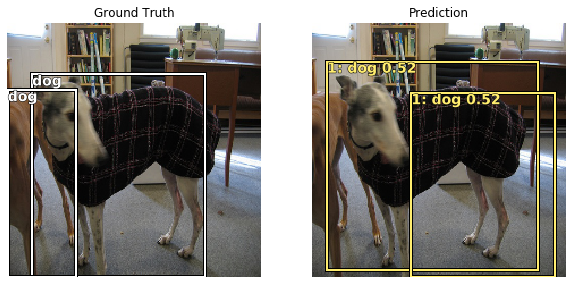

In [0]:
# Show Single Image 
show_filtered_img_by_ndx(25, data_classes)

Inferred Class is not recognized. It may be under the threshold.


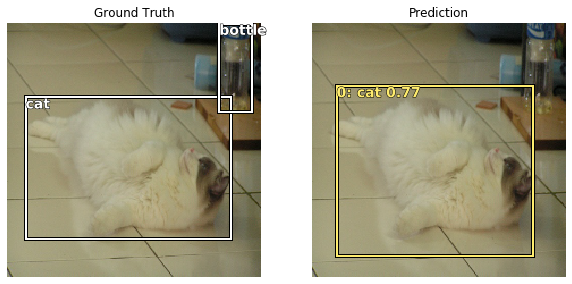

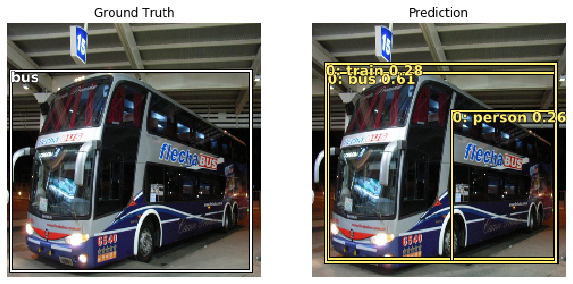

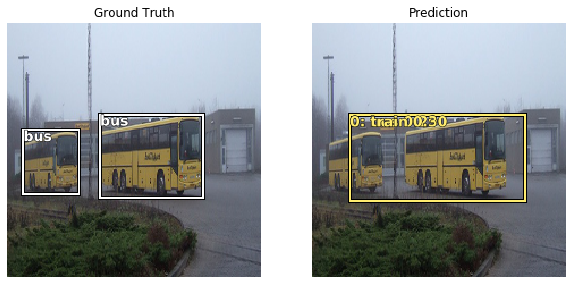

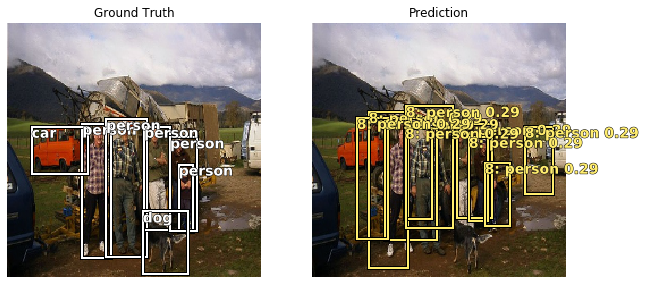

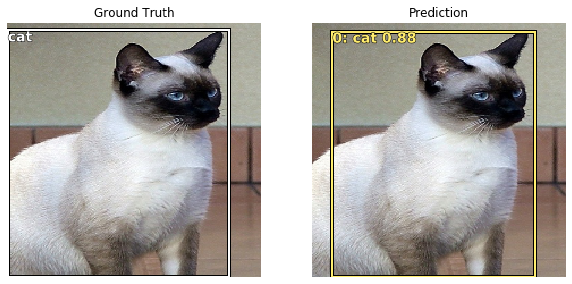

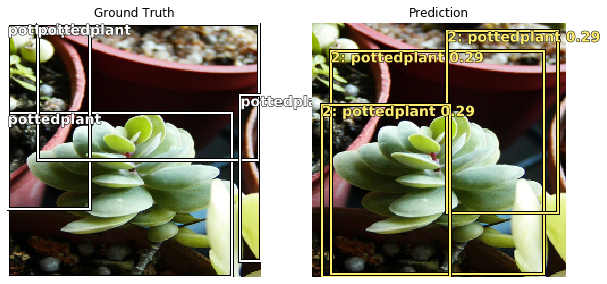

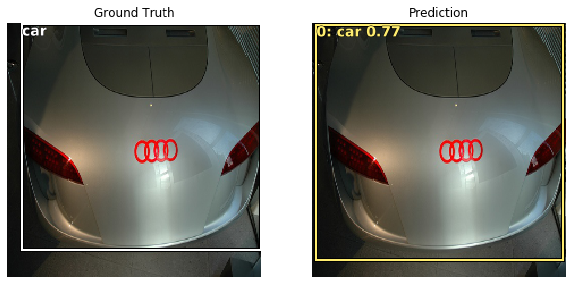

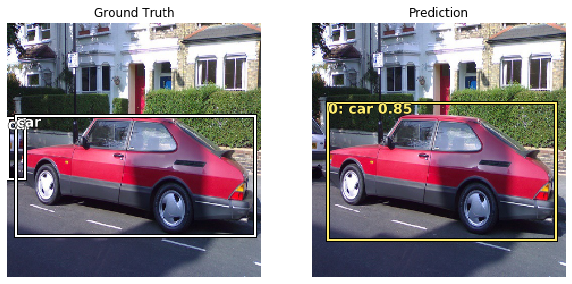

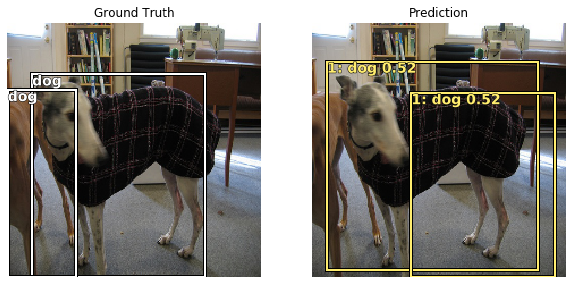

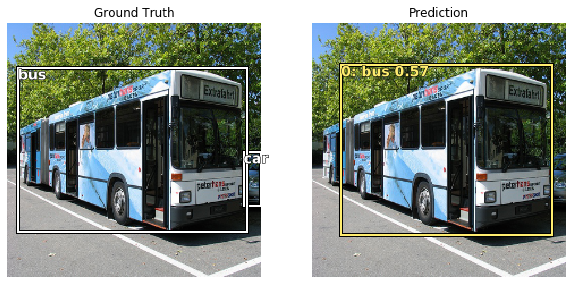

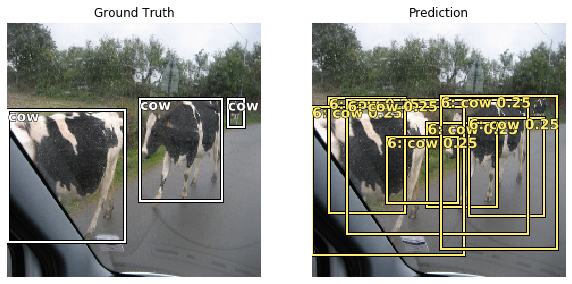

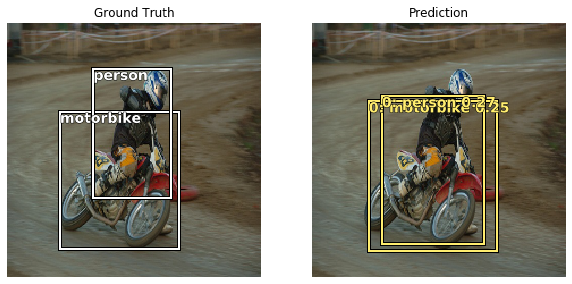

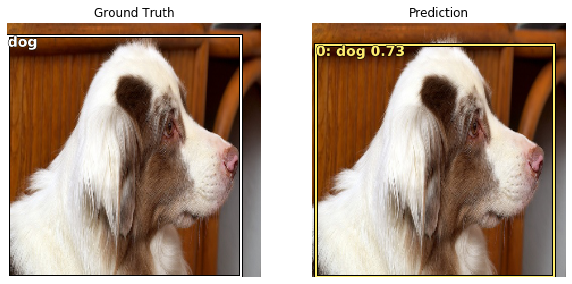

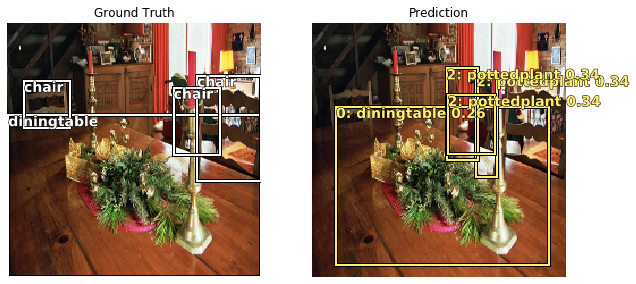

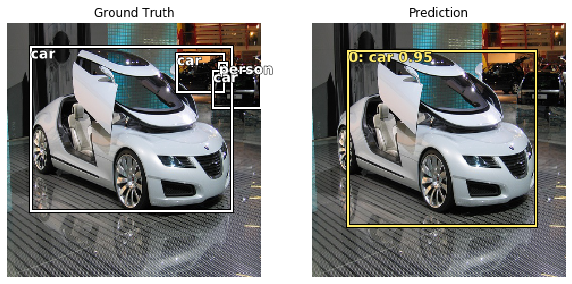

In [0]:
# Show image data sets, given their index span
for i in range(16,32): show_filtered_img_by_ndx(i, data_classes)

## Model Inference with External Images
The section below tests the model with images that the model has never 'seen' before. The code below is kind of a hack. i have not been able to find an elegant method to infer external images using Fastai. If someone has a better way, I would love to learn from you. It is a pity that, given the advanced state of the Fastai library, it has yet to develop an adequate inference mechanism.
The code can be detached into a self-contained notebook that can be run in a separate computer. However, to run correctly, you must include a number of code cells from the main notebook. These are given by the cell heading name:

  ssd_loss

  ssd_model

  Helper Functions

  Helper Functions - Anchor Boxes

  Color Coding setup
  
  NMS Algorithm  (NMS, and process_nmf)

If you want to run the inference in a separate computer, I suggest you convert all the code listed above into .py files that you can refer to by means of import statements.

### Initialization

In [0]:
# ********************************************************************
# Run these cells only if you are running on a separate computer
#*********************************************************************
from google.colab import drive
drive.mount('/content/gdrive')
from google.colab import files

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from fastai.vision import *
from fastai import *
from fastai.callbacks import *
import fastai
__version__

'1.0.60'

### Force the inference code to run under cpu only
Otherwise, you are likely to run out of GPU memory

In [0]:
# Force Fastai to run on the CPU only
device = torch.device('cpu') 
fastai.torch_core.defaults.device = 'cpu'

### Load Test dataset and Create a Databunch
The databunch receives external images from the Test dataset. 

In [0]:
sz=224       # Image size
bs = 32     # Batch size
tfms=get_transforms()

In [0]:
#This is a hack! This data block reads external images into a databuch. 
test_data = (ImageList.from_folder(path)       
         .split_none()                    
         .label_from_folder()             
         .add_test_folder('test')    #Add a test set (here default name is test_real)
         .transform(tfms, size=sz)        
         .databunch(bs=bs)
         .normalize(imagenet_stats)
          )     

### Load Model 
Load the model, which was generated during the training phase and exported into a .pkl file

In [0]:
test_learn = load_learner(path=F'/content/gdrive/My Drive', file='model_export.pkl')
test_learn.data = test_data

### Infer

Infer from external images taken from the test dataset

In [0]:
# Link with the test dataset
tr = iter(test_learn.data.test_dl)

In [0]:
# Get batch from the test dataset
xb,yb = next(tr)
test_learn.model.eval()
preds = test_learn.model(xb)
b_bb, b_clas = preds

In [0]:
# Read Data Classes for use in predicting external images
with open(F'/content/gdrive/My Drive/ssd_classes', 'rb') as fp:
    data_classes = pickle.load(fp)

#### Infer single image without NMS

In [0]:
# Show image given its index
def show_img_by_ndx(idx):
    # Prepare ground-truth image for display 
    #t_bbox,t_clas = un_pad(yb[0][idx],yb[1][idx])
    p_cls_test = preds[1][idx][:,1:].max(dim=1)
    idx_clas = p_cls_test[0].sigmoid() > 0.1
    p_f_clas = (p_cls_test[1] + 1) * (idx_clas).long()
  
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))  

    p_final_bbox = act_to_bbox(preds[0][idx].cpu(),anchors)
    
    t_bbox = p_final_bbox.to(device).index_select(dim=0,index=idx_clas.nonzero().squeeze())
    test_clas = p_f_clas.index_select(dim=0,index=idx_clas.nonzero().squeeze())

    p_img_box = ImageBBox.create(224,224,t_bbox.cpu(),test_clas,classes=data_classes,scale=False)

    fig,axes = plt.subplots(1,1, figsize=(15,8))

    img.show(ax=axes,y=p_img_box,title='Prediction')

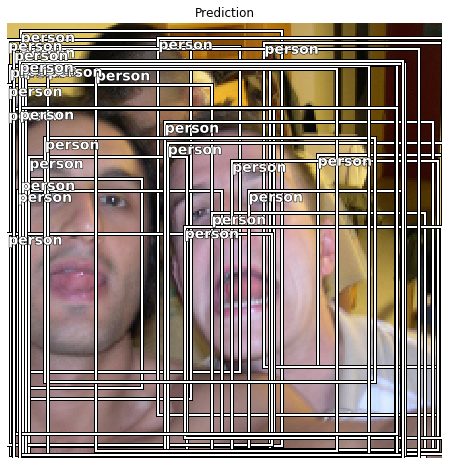

In [0]:
show_img_by_ndx(3)

#### Infer image sets with NMS

In [0]:
# Filter images with NMS given its index
def show_filtered_img_by_ndx(idx, d_classes):
      
    # Prepare ground-truth image for display 
    img = vision.Image(denormalize(xb[idx],*tensor(imagenet_stats)))  
        
    # Prrocess NMF 
    tot_bx, tot_cls, scrd_cls_lst = process_nmf(idx, d_classes)  # Filter dupplicate boxes
    if tot_bx is None: return 
    
    # Compose the image, bouding boxes, and classes for display
    p_img_box = ImageBBox.create(224,224,tot_bx.cpu(),tot_cls.cpu(),classes=scrd_cls_lst,scale=False)
  
    # Display resulting image, selected bounding boxes, and class labels
    fig,axes = plt.subplots(1,1,figsize=(10,10))
    img.show(ax=axes,y=p_img_box,title='Prediction', color=colr_list[11])
   

Inferred Class is not recognized. It may be under the threshold.


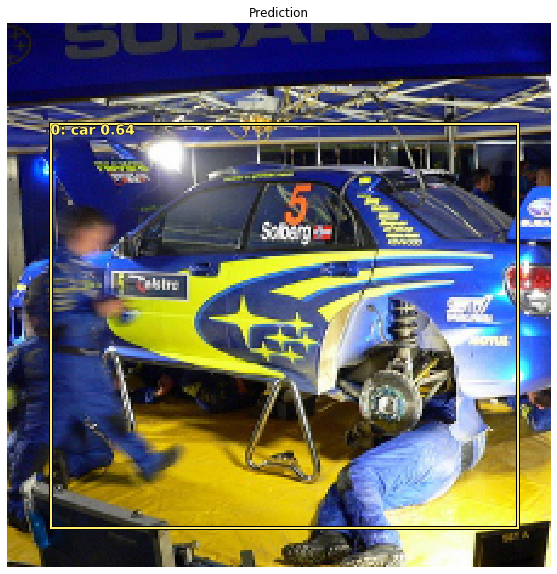

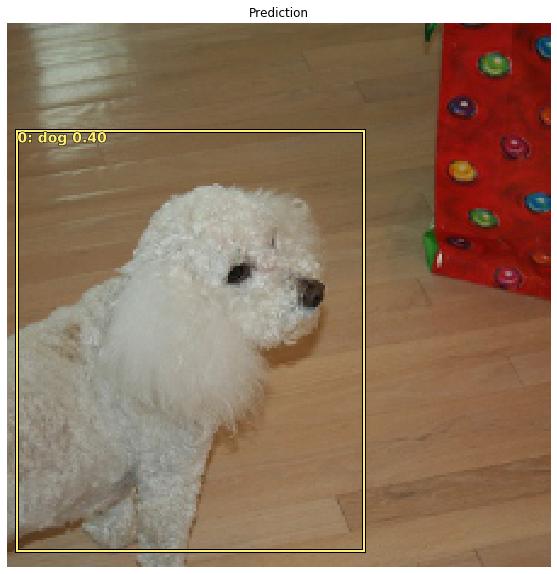

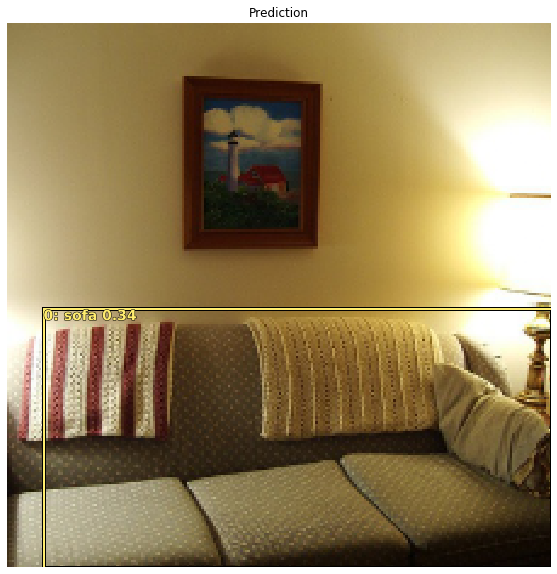

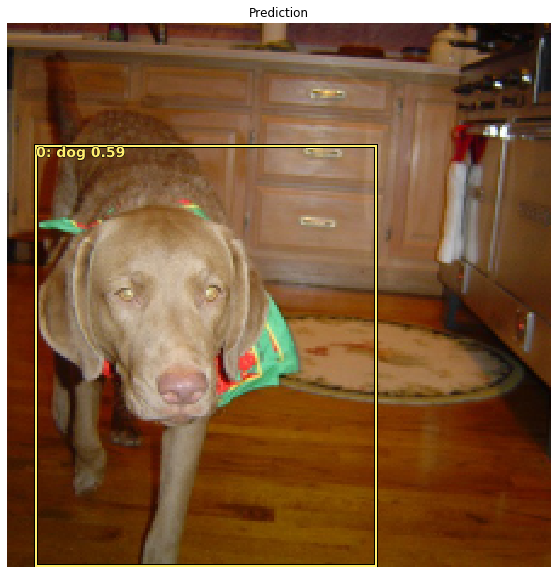

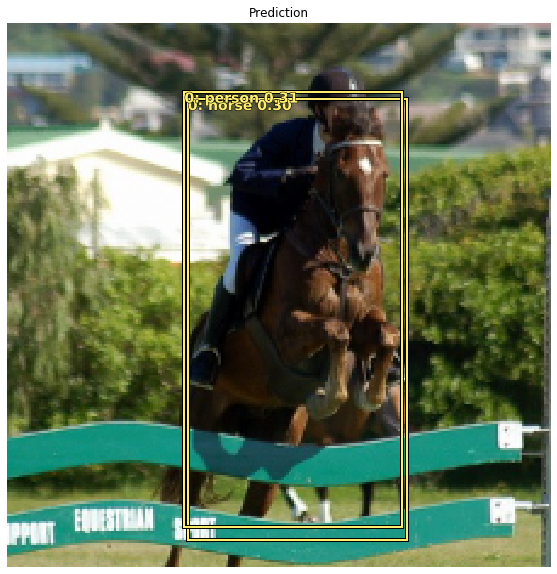

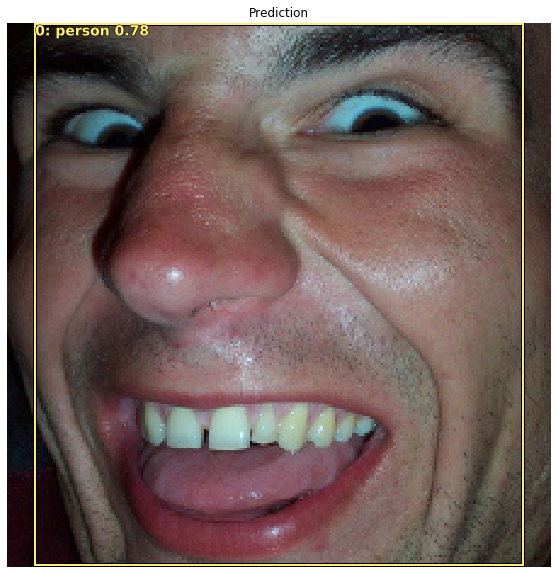

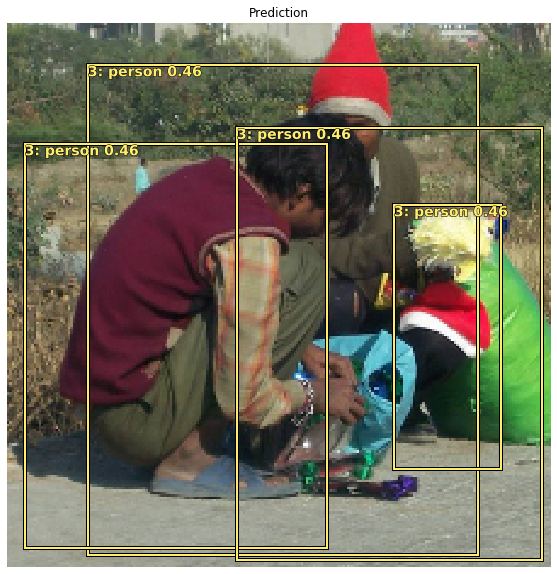

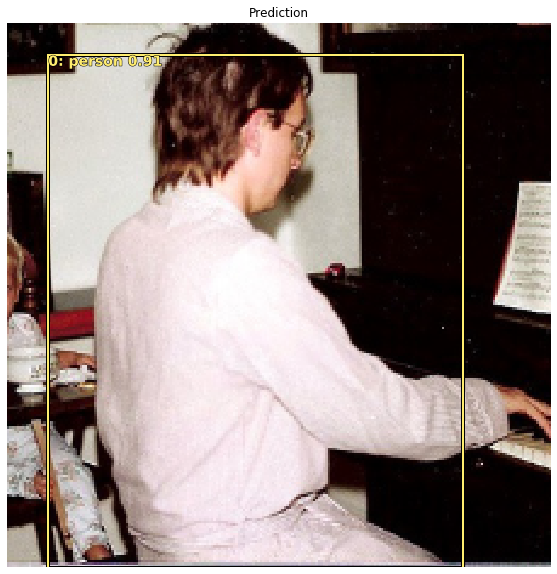

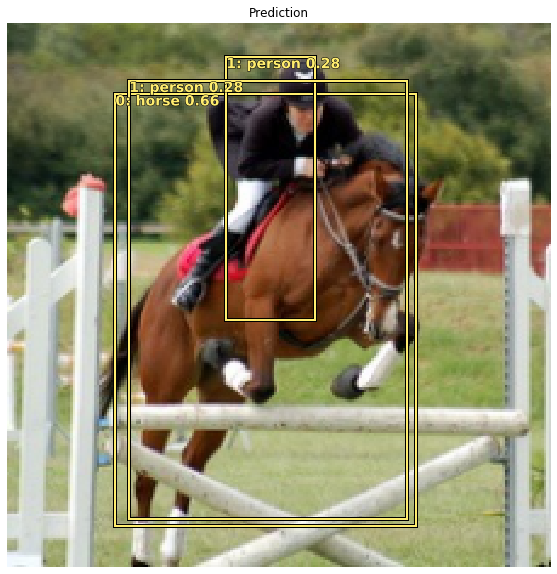

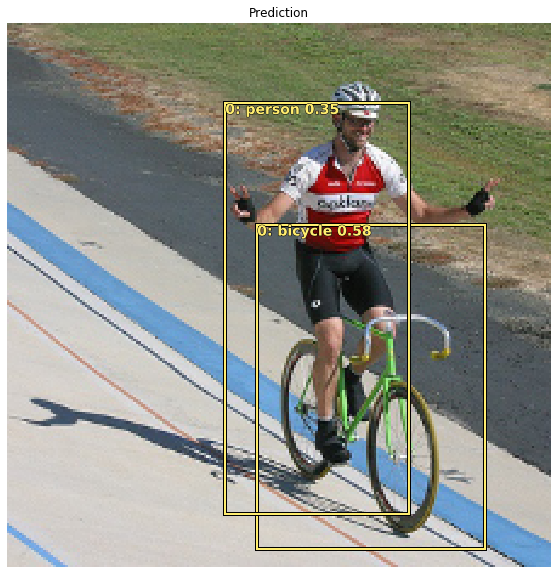

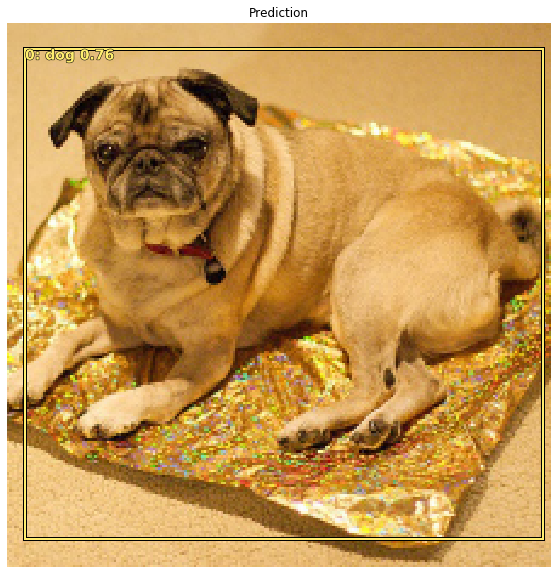

In [0]:
#Filter Image Sets
for i in range(0,12): show_filtered_img_by_ndx(i, data_classes)

# FIN